# Setup

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
from src import (get_data as gd, 
                 prepare as prep, 
                 aggregate_data as aggregate,
                 push_data,
                 sedi_rate,
                 age_sr_plot)
###
orig_dir = os.getcwd()

# Main Data

### Retrieve data 

In [2]:
dates = gd.AgeFromFileOneCore()

FileChooser(path='/home/jovyan/work/input_files', filename='', title='', show_hidden=False, select_desc='Selec…

In [3]:
dates.get_dates()

### Add calibration curve to data

In [4]:
dates.select_calibration_curve(default_curve = 'IntCal20', user_selection = False)

In [5]:
dates.add_calibration_curve()

### Put data in variables

In [6]:
AllAges = dates.all_ages
CoreIDs = dates.all_coreid_list
CoreLengths = dates.all_core_lengths
SR_mode = 'naive'

In [7]:
aggRC = lambda: None
aggRC.dttp = "No"

# Reservoir correction

#### Prep

In [8]:
os.chdir(orig_dir)
RC = prep.PrepForReservoirCorrection(all_ages = AllAges)
RC.prep_it()
RC_Frame = RC.RC_Frame
RC_CoreIDs = RC.RC_CoreIDs
RC_CoreLengths = CoreLengths[CoreLengths.coreid.isin(RC_CoreIDs)]

#### R run

In [9]:
%get RC_Frame
%get RC_CoreIDs 
%get RC_CoreLengths

In [10]:
K_fine <- 100
source('src/Run_DefineReservoir.R', local = TRUE)

In [11]:
%put reservoir_core_results

#### Aggregate results

In [12]:
aggRC = aggregate.AggDataReservoir(results = reservoir_core_results,
                                   surface_dates = RC.desired_surface_dates,
                                   verbose = 0)
aggRC.results_agg()

In [13]:
AllAges = aggRC.add_reservoir(all_ages = AllAges)

# Calibration
#### Prep

In [8]:
calib = prep.PrepForCalibration(all_ages = AllAges)
calib.prep_it()
calib_Frame = calib.calib_Frame

#### R run

In [9]:
%get calib_Frame --from SoS

In [10]:
source('src/Run_calibration.R', local = TRUE)

In [11]:
%put calib_dates

# Age Modeling
### UNDATABLE
#### Prep

In [18]:
Undatable = prep.PrepForUndatable(all_ages = AllAges, 
                                  all_coreid_list = CoreIDs)
Undatable.prep_it()
CoreID_array = Undatable.CoreID_array

Information: New files for Undatable created!


#### Octave run

In [19]:
%get CoreID_array


a =

  scalar structure containing the fields:

    obj =
    {
      [1,1] = EN18218
    }


repr =
{
  [1,1] = EN18218
}

CoreID_array =
{
  [1,1] = EN18218
}



In [20]:
xfactor = 0.1;
bootpc = 30;
run_Undatable(CoreID_array, xfactor, bootpc);

#### Aggregate results

In [21]:
aggU = aggregate.AggDataUndatable(Undatable, orig_dir, dttp = aggRC.dttp)
aggU.results_agg()

#### Calculate sedimentation rate

In [22]:
SRUn = sedi_rate.CalculateSediRate(aggU, model = 'Undatable', coreid = CoreIDs, mode = SR_mode)
SRUn.calculating_SR()

#### Push results to database

In [23]:
push = push_data.PushIt(agg = aggU,
                        engine = dates.engine,
                        model = 'Undatable')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


In [24]:
os.chdir(orig_dir)
push.delete_files(location_UndatableFolder = Undatable.location_UndatableFolder,
                  coreids = Undatable.coreid_df)

Information: All unwanted Undatable files have been deleted


### Bchron

#### Prep

In [25]:
os.chdir(orig_dir)
Bchron = prep.PrepForBchron(all_ages = AllAges)
Bchron.prep_it()
Bchron_Frame = Bchron.Bchron_Frame

#### R run

In [26]:
%get Bchron_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [27]:
source('src/Run_Bchron.R')

Running Bchronology...
  |============================================================| 100%
Run completed!


 Done with core EN18218 - Number 1 out of 1



In [28]:
%put Bchron_core_results

#### Aggregate results

In [29]:
aggBc = aggregate.AggDataBchron(Bchron_core_results, dttp = aggRC.dttp)
aggBc.results_agg()

#### Calculating sedimentation rate

In [30]:
SRBc = sedi_rate.CalculateSediRate(aggBc, model = 'Bchron', coreid = CoreIDs, mode = SR_mode)
SRBc.calculating_SR()

#### Push results to database

In [31]:
push = push_data.PushIt(agg = aggBc,
                        engine = dates.engine,
                        model = 'Bchron')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


### hamstr

#### Prep

In [32]:
hamstr = prep.PrepForHamstr(all_ages = AllAges)
hamstr.prep_it()
hamstr_Frame = hamstr.hamstr_Frame

#### R Run

In [33]:
%get hamstr_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [34]:
K_fine <- 100
source('src/Run_hamstr.R', local = TRUE)

Done with core: EN18218



In [35]:
%put hamstr_core_results

#### Aggregate

In [36]:
aggh = aggregate.AggDataHamstr(hamstr_core_results, dttp = aggRC.dttp)
aggh.results_agg()

#### Calculating sedimentation rate

In [37]:
SRh = sedi_rate.CalculateSediRate(aggh, model = 'hamstr', coreid = CoreIDs, mode = SR_mode)
SRh.calculating_SR()

#### Push results to database

In [38]:
push = push_data.PushIt(agg = aggh,
                        engine = dates.engine,
                        model = 'hamstr')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


### Bacon

#### Prep

In [12]:
Bacon = prep.PrepForBacon(all_ages = AllAges)
Bacon.prep_it()
Bacon_Frame = Bacon.Bacon_Frame

#### R Run

In [68]:
%get Bacon_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS
%get calib_dates --from SoS

In [99]:
acc.shape <- 1.5
acc.mean <- 20
mem.strength <- 10
mem.mean <- 0.5
ssize <- 10000
rbacon.change.acc.mean <- TRUE
rbacon.change.thick <- TRUE
source('src/Run_Bacon.R', local = TRUE)

Previous runs of core TestCore with thick=5 cm deleted. Now try running the core again




starting worker for localhost:11299 
Type: EXEC 
Type: EXEC 


Loading required package: foreach
Loading required package: rngtools
Running Bacon for core EN18218 (attempt 1)
 Using calibration curve specified within the .csv file,0

Adapting acc.mean to 50 yr/cm
 Will run 46,900,000 iterations and store 10,000


The run's files will be put in this folder: /tmp/RtmpdzsWDo/EN18218
Reading /tmp/RtmpdzsWDo/EN18218/EN18218_132.bacon
Constant calibration curve.
IntCal20: Reading from file: /opt/conda/lib/R/library/rintcal/extdata/3Col_intcal20.14C
Marine20: Reading from file: /opt/conda/lib/R/library/rintcal/extdata/3Col_marine20.14C
SHCal20: Reading from file: /opt/conda/lib/R/library/rintcal/extdata/3Col_shcal20.14C
Added det: EN18218:  -38.2+-43.2   d=0.25 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18218: 1855.1+-82.6   d=18.75 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18218: 2885.0+-76.5   d=35.25 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18218: 3150.8+-99.5   d=59.75 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18218: 4663.9+-101.3  d=81.25 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18218: 5216.7+-126.1  d=114.75 ResCorr=   0.0+-0.0    a=3 b=4 cc=Constant c. curve
Added det: EN18218: 47

Warning, this will take quite some time to calculate. I suggest increasing d.by to, e.g., 10

Calculating age ranges...


  |======================================================================| 100%


Preparing ghost graph... 


  |======================================================================| 100%


Mean 95% confidence ranges 1064 yr, min. 199 yr at 0.25 cm, max. 3384 yr at 560.25 cm
100% of the dates overlap with the age-depth model (95% ranges)
Posteriors: accrate mean 44.43, shape 0.85, memory mean 0.46, strength 13.75
✅ ages_matrix shape: 133 depths × 10000 iterations
🔎 Interpolation check:
Depth range: 0.00–653.00 cm
Deepest modeled age: min=1.1, mean=50.4, max=247.3
✅ 10000 iterations achieved
✅ Done with core EN18218


Type: DONE 


Warning message:
In interpolate_bacon_output_ff(run, depth_seq = seq(0, depth_max,  :
  ⚠️ Deepest modeled age is <10,000 cal BP — check input ages or d.max


In [96]:
Bacon_core_results

Error in unserialize(node$con) : error reading from connection
Calls: local ... doTryCatch -> recvData -> recvData.SOCKnode -> unserialize
Execution halted
Error in unserialize(node$con) : error reading from connection
Calls: local ... doTryCatch -> recvData -> recvData.SOCKnode -> unserialize
Execution halted


,depth,iter_1,iter_2,iter_3,iter_4,iter_5,iter_6,iter_7,iter_8,iter_9,⋯,iter_9991,iter_9992,iter_9993,iter_9994,iter_9995,iter_9996,iter_9997,iter_9998,iter_9999,iter_10000
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,EN18218 0,-25.766300,38.451000,37.86880,39.84960,48.36300,50.66490,84.00070,61.02020,-25.76970,⋯,-49.764000,-37.389400,-36.14310,2.48569,-9.51557,-30.957100,-33.915900,-8.968880,-9.699090,-24.53880
2,EN18218 1,-21.246181,33.819119,37.34385,39.52311,46.47900,44.33909,72.35145,53.91943,-19.85199,⋯,-31.963995,-20.599165,-19.08603,16.82752,6.32000,-17.108995,-19.623975,-1.178243,1.021663,-11.59209
3,EN18218 2,-15.219355,27.643276,36.64391,39.08779,43.96700,35.90469,56.81912,44.45173,-11.96171,⋯,-8.230655,1.787815,3.65673,35.94996,27.43409,1.355145,-0.568075,9.209273,15.316001,5.67019
4,EN18218 3,-9.192529,21.467434,35.94396,38.65247,41.45500,27.47028,41.28679,34.98403,-4.07143,⋯,15.502685,24.174795,26.39949,55.07241,48.54819,19.819285,18.487825,19.596789,29.610340,22.93247
5,EN18218 4,-3.165703,15.291593,35.24403,38.21715,38.94300,19.03587,25.75446,25.51633,3.81885,⋯,39.236025,46.561775,49.14225,74.19485,69.66228,38.283425,37.543725,29.984305,43.904677,40.19475
6,EN18218 5,2.861123,9.115751,34.54409,37.78183,36.43100,10.60146,10.22213,16.04863,11.70913,⋯,62.969365,68.948755,71.88501,93.31729,90.77638,56.747565,56.599625,40.371821,58.199015,57.45703
7,EN18218 6,34.766705,41.233171,60.50944,60.83180,63.56680,43.03173,41.20099,49.69570,49.69570,⋯,84.788195,88.096725,89.53924,106.98736,105.25082,76.306060,76.306060,60.670395,76.653710,76.65371
8,EN18218 7,75.298539,86.115014,95.36321,91.71020,100.58520,89.08356,87.68358,97.71435,97.71435,⋯,105.968855,106.165025,105.49730,118.83998,117.51203,96.229340,96.229340,84.272655,96.495190,96.49519
9,EN18218 8,115.830374,130.996856,130.21699,122.58860,137.60360,135.13539,134.16617,145.73302,145.73302,⋯,127.149515,124.233325,121.45537,130.69260,129.77326,116.152620,116.152620,107.874915,116.336670,116.33667


In [79]:
%put Bacon_core_results

#### Aggregate

In [80]:
aggBa = aggregate.AggDataBacon(Bacon_core_results, dttp = aggRC.dttp)
aggBa.results_agg()

#### Calculating sedimentation rate

In [81]:
SRBa = sedi_rate.CalculateSediRate(aggBa, model = 'Bacon', coreid = CoreIDs, mode = SR_mode)
SRBa.calculating_SR()

#### Push results to database

In [82]:
push = push_data.PushIt(agg = aggBa,
                        engine = dates.engine,
                        model = 'Bacon')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


### Clam

#### Prep

In [54]:
clam = prep.PrepForClam(all_ages = AllAges)
clam.prep_it()
clam_Frame = clam.clam_Frame

#### R Run

In [55]:
%get clam_Frame --from SoS
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [56]:
types_curve <- 1:5
smoothness_curve <- 0.1*(1:10)
poly_degree_curve <- 1:4
best_fit <- TRUE

In [57]:
source('src/Run_clam.R', local = TRUE)

🌍 Starting core EN18218 (1 of 1)



starting worker for localhost:11348 
starting worker for localhost:11348 
starting worker for localhost:11348 
starting worker for localhost:11348 
starting worker for localhost:11348 
starting worker for localhost:11348 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
Type: EXEC 
 extrapolating beyond dated levels, dangerous!
  extrapolating beyond dated levels, dangerous!
  extrapolating beyond dated levels, dangerous!
  extrapolating beyond dated levels, dangerous!
  extrapolating beyond dated levels, dangerous!
  extrapolating beyond dated levels, dangerous!
  Interpolating, sampling..........

📏 Fit for EN18218 — clam type 3: 28.93
✅ Finished core EN18218 — clam type 3


Type: EXEC 
 extrapolating beyond dated levels, dangerous!
 

📏 Fit for EN18218 — clam type 1: 27.26
✅ Finished core EN18218 — clam type 1


Type: EXEC 
 extrapolating beyond dated levels, dangerous!
 ..................

📏 Fit for EN18218 — clam type 4 smoothing 0.1: 71.2
✅ Finished core EN18218 — clam type 4 smoothing 0.1


Type: EXEC 
 extrapolating beyond dated levels, dangerous!
 

📏 Fit for EN18218 — clam type 4 smoothing 0.2: 82.76
✅ Finished core EN18218 — clam type 4 smoothing 0.2


Type: EXEC 
 extrapolating beyond dated levels, dangerous!
 ..............

📏 Fit for EN18218 — clam type 4 smoothing 0.3: 150.84
✅ Finished core EN18218 — clam type 4 smoothing 0.3


Type: EXEC 
 extrapolating beyond dated levels, dangerous!
 .

📏 Fit for EN18218 — clam type 4 smoothing 0.4: 283.19
✅ Finished core EN18218 — clam type 4 smoothing 0.4


.Type: EXEC 
 extrapolating beyond dated levels, dangerous!
 ............

📏 Fit for EN18218 — clam type 2 degree 1: NA
✅ Finished core EN18218 — clam type 2 degree 1


.

📏 Fit for EN18218 — clam type 2 degree 2: NA
✅ Finished core EN18218 — clam type 2 degree 2


..Type: EXEC 
Type: EXEC 
 extrapolating beyond dated levels, dangerous!
  extrapolating beyond dated levels, dangerous!
 

📏 Fit for EN18218 — clam type 2 degree 3: 2180.5
✅ Finished core EN18218 — clam type 2 degree 3


Type: EXEC 
 extrapolating beyond dated levels, dangerous!
 .

📏 Fit for EN18218 — clam type 2 degree 4: 1201.4
✅ Finished core EN18218 — clam type 2 degree 4
📏 Fit for EN18218 — clam type 4 smoothing 0.5: 485.81
✅ Finished core EN18218 — clam type 4 smoothing 0.5


Type: EXEC 
Type: EXEC 
 extrapolating beyond dated levels, dangerous!
 ..

📏 Fit for EN18218 — clam type 4 smoothing 0.6: 602.92
✅ Finished core EN18218 — clam type 4 smoothing 0.6


Type: EXEC 
...................

📏 Fit for EN18218 — clam type 4 smoothing 0.7: 883.8
✅ Finished core EN18218 — clam type 4 smoothing 0.7
📏 Fit for EN18218 — clam type 4 smoothing 0.8: 1436.9
✅ Finished core EN18218 — clam type 4 smoothing 0.8


.Type: EXEC 
Type: EXEC 


📏 Fit for EN18218 — clam type 4 smoothing 0.9: 2203.5
✅ Finished core EN18218 — clam type 4 smoothing 0.9


.Type: EXEC 


📏 Fit for EN18218 — clam type 4 smoothing 1.0: 2872.9
✅ Finished core EN18218 — clam type 4 smoothing 1.0


.Type: EXEC 
.................

📏 Fit for EN18218 — clam type 5 smoothing 0.2: 130.12
✅ Finished core EN18218 — clam type 5 smoothing 0.2


Type: EXEC 
.....

📏 Fit for EN18218 — clam type 5 smoothing 0.1: 28.02
✅ Finished core EN18218 — clam type 5 smoothing 0.1


Type: EXEC 
....

📏 Fit for EN18218 — clam type 5 smoothing 0.4: 634.73
✅ Finished core EN18218 — clam type 5 smoothing 0.4


.Type: EXEC 
..

📏 Fit for EN18218 — clam type 5 smoothing 0.5: 1070.7
✅ Finished core EN18218 — clam type 5 smoothing 0.5


Type: EXEC 


📏 Fit for EN18218 — clam type 5 smoothing 0.3: 551.88
✅ Finished core EN18218 — clam type 5 smoothing 0.3
📏 Fit for EN18218 — clam type 5 smoothing 0.6: 1764.4
✅ Finished core EN18218 — clam type 5 smoothing 0.6


............

📏 Fit for EN18218 — clam type 5 smoothing 0.7: 2195.1
✅ Finished core EN18218 — clam type 5 smoothing 0.7


...

📏 Fit for EN18218 — clam type 5 smoothing 0.8: 2396.6
✅ Finished core EN18218 — clam type 5 smoothing 0.8


..

📏 Fit for EN18218 — clam type 5 smoothing 0.9: 2686.8
✅ Finished core EN18218 — clam type 5 smoothing 0.9
📏 Fit for EN18218 — clam type 5 smoothing 1.0: NA
✅ Finished core EN18218 — clam type 5 smoothing 1.0


Type: DONE 
Type: DONE 
Type: DONE 
Type: DONE 
Type: DONE 
Type: DONE 


In [58]:
%put clam_core_results

#### Aggregate

In [59]:
aggcl = aggregate.AggDataClam(clam_core_results, dttp = aggRC.dttp)
aggcl.results_agg()

#### Calculating sedimentation rate

In [60]:
SRcl = sedi_rate.CalculateSediRate(aggcl, model = 'clam', coreid = CoreIDs, mode = SR_mode)
SRcl.calculating_SR()

#### Push results to database

In [61]:
push = push_data.PushIt(agg = aggcl,
                        engine = dates.engine,
                        model = 'clam')
push.push_to_db()

Information: LANDO is not connected to a database, so nothing was uploaded.


# Plotting

In [83]:
plot_data = {#'Undatable' : [aggU.age_model_result_Undatable, SRUn.SR_model_result_Undatable],
             #'Bchron': [aggBc.age_model_result_Bchron, SRBc.SR_model_result_Bchron],
             #'hamstr': [aggh.age_model_result_hamstr, SRh.SR_model_result_hamstr],
             'Bacon': [aggBa.age_model_result_Bacon, SRBa.SR_model_result_Bacon],
             #'clam': [aggcl.age_model_result_clam, SRcl.SR_model_result_clam],
             'calib_dates': calib_dates}

In [84]:
ASRplot = age_sr_plot.PlotAgeSR(plot_data, coreid = CoreIDs, dttp = aggRC.dttp)

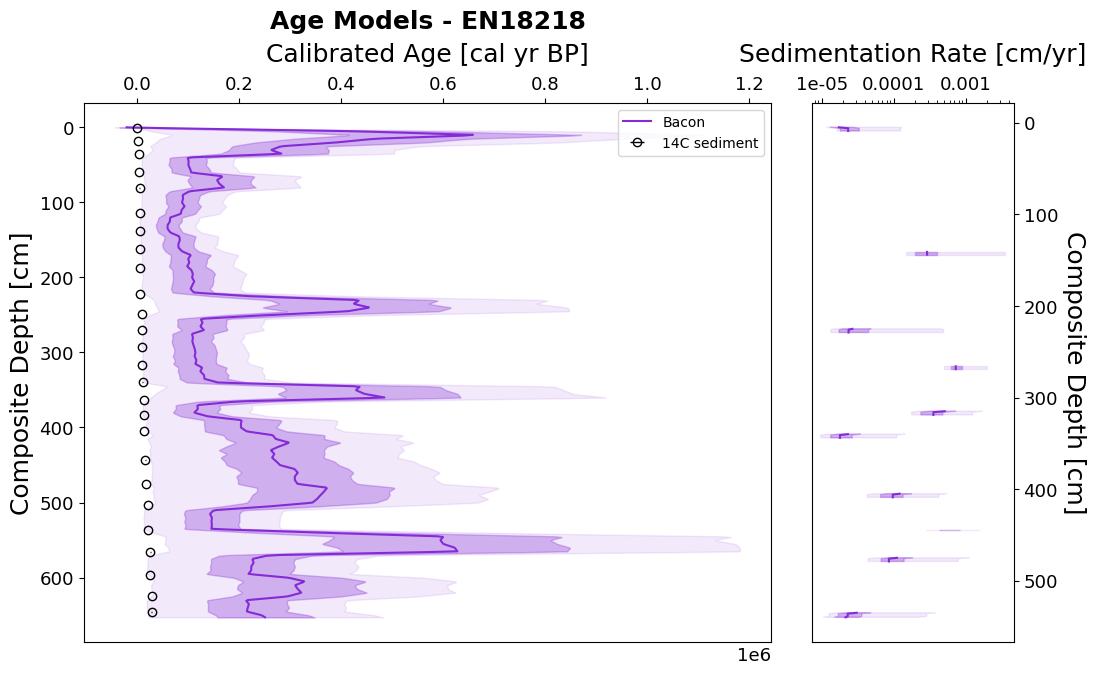

In [85]:
ASRplot.plot_graph(orig_dir = orig_dir, sigma_range = 'both',
                   bin_size = 1000, xlim_max = 21000, number_col = 8, reduce_plot_axis = True,
                   only_combined = False, save = False, for_color_blind = False, as_jpg = False)

# Optimization

In [ ]:
proxy = gd.ProxyFromFile()

In [ ]:
proxy_ts = proxy.get_proxy()
###
dict_model_name = ASRplot.dict_model_name
dict_SR_median_age = ASRplot.dict_SR_median_age

In [ ]:
%get dict_SR_median_age --from SoS
%get dict_model_name --from SoS
%get proxy_ts --from SoS

In [ ]:
curr_nreps     <- 1000
curr_minseg    <- 50
curr_cptmethod <- "mean+variance"

In [ ]:
source('src/Run_Optimization.R', local = TRUE)

In [ ]:
%put result_list 
%put fitting_values

In [ ]:
optimizedASRplot = age_sr_plot.PlotAgeSR(plot_data, coreid = CoreIDs, dttp = aggRC.dttp)

In [ ]:
optimizedASRplot.plot_optimized_graph(optimization_values = result_list, fitting_values = fitting_values, 
                                      proxy = proxy.name, proxy_data = proxy_ts, orig_dir = orig_dir, 
                                      sigma_range = 'both', inclusion_threshold = 0.03, show_fitting_models = True,
                                      bin_size = 1000, xlim_max = 21000, number_col = 8, reduce_plot_axis = True,
                                      only_combined = True, save = True, for_color_blind = False, as_jpg = False)